# Add Folders to Path

In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/General_Functions")

CPU times: user 299 µs, sys: 156 µs, total: 455 µs
Wall time: 351 µs


# Agulhas

## Import data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

CPU times: user 144 ms, sys: 41.6 ms, total: 186 ms
Wall time: 185 ms


## Data/Parameters for dynamical system

In [3]:
%%time
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 20

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, 
               "Incompressible": Incompressible, "Periodic": Periodic}

CPU times: user 199 µs, sys: 74 µs, total: 273 µs
Wall time: 240 µs


<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
## Spatio-temporal domain of dynamical system

In [4]:
%%time
# time (in days)
t = 10

time = [t]

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = 5
ymin = -35
ymax = -30

# spacing of meshgrid (in degrees)
dx = 0.1
dy = 0.1

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

CPU times: user 229 µs, sys: 138 µs, total: 367 µs
Wall time: 260 µs


In [5]:
%%time
# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *
DS = Dynamical_System(params_data, params_DS)

CPU times: user 64.4 ms, sys: 11.2 ms, total: 75.6 ms
Wall time: 74.8 ms


## Velocity interpolation

In [6]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 187 ms, sys: 29.4 ms, total: 216 ms
Wall time: 219 ms


## Compute rate of strain tensor $ S(\mathbf{x},t) $ over meshgrid

In [7]:
%%time
from tqdm.notebook import tqdm

S = np.zeros((X_domain.shape[0], X_domain.shape[1], 2, 2))

for i in tqdm(range(S.shape[0])):
    
    for j in range(S.shape[1]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        S[i, j, :, :] = DS._spin_tensor(x, t)

  0%|          | 0/52 [00:00<?, ?it/s]

CPU times: user 1.15 s, sys: 8.01 ms, total: 1.16 s
Wall time: 1.16 s


## Identify vortex centers from local maximum of instantaneous IVD

Centers of elliptic OECS are given by local maxima in the IVD field.

In [8]:
%%time
from ipynb.fs.defs.loc_max import _loc_max

sys.path.append(parent_directory+"/Demos/IVD")
from ipynb.fs.defs.IVD import _IVD

IVD = _IVD(X_domain, Y_domain, DS, time)

# distance between local maxima
max_distance = 1.5

x_vortex, y_vortex, _ = _loc_max(max_distance, X_domain, Y_domain, IVD)

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

CPU times: user 1.47 s, sys: 12.9 ms, total: 1.48 s
Wall time: 1.47 s


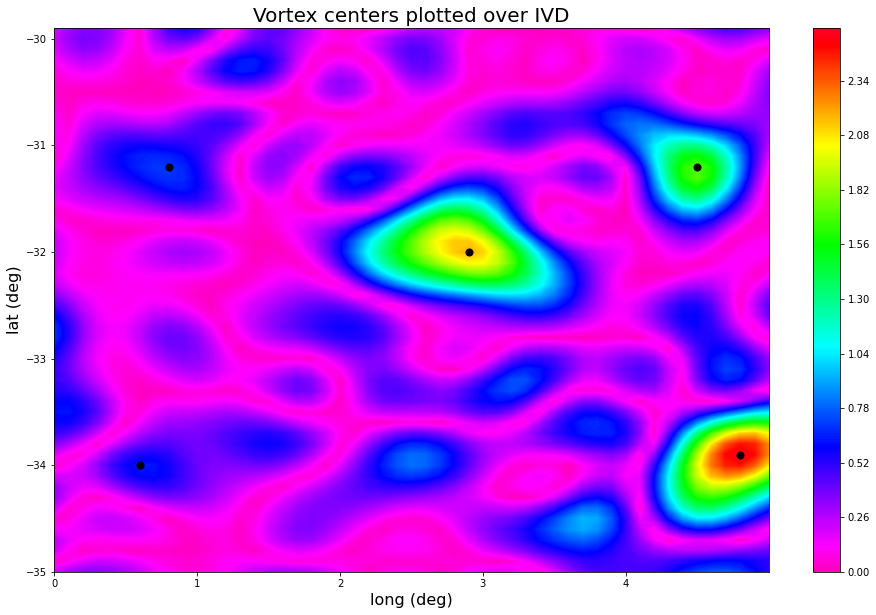

In [9]:
###################################### PLOT VORTEX CENTERS FROM IVD ######################################
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()

cax = ax.contourf(X_domain, Y_domain, IVD, levels=600, cmap='gist_rainbow_r')
ax.scatter(x_vortex, y_vortex, s = 50, c = 'k', label='Vortex center')

ax.set_xlabel('long (deg)', fontsize = 16)
ax.set_ylabel('lat (deg)', fontsize = 16)

ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

ax.set_title('Vortex centers plotted over IVD', fontsize = 20)

cbar = plt.colorbar(cax)
plt.show()

## Shearlines (Elliptic OECS)

Elliptic LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0(s) = \sqrt{\dfrac{s_2-\mu}{s_2-s_1}}\xi_2(\mathbf{x}_0;t_0, t_N) \pm\sqrt{\dfrac{s_1-\mu}{s_2-s_1}}\xi_1(\mathbf{x}_0;t_0, t_N),
\label{eq: shearlines}
\end{equation}

with $ \xi_1, \xi_2 $ denoting the eigenvector associated to the weakest/strongest eigenvalue $ \lambda_1/\lambda_2 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The outermost closed shearline mark initial positions of elliptic LCS at time $ t_0 $. The integration of the autonomous system in eq. \ref{eq: shearlines} is done with respect to the non-dimensional parameter $ s $.

In [10]:
%%time
from ipynb.fs.defs.shearlines import _shearlines
from ipynb.fs.defs.outermost_closed_shearline import _outermost_closed_shearline
import matplotlib.pyplot as plt

# step-size used for integration with respect to parameter 's'
step_size = 0.025

# range of mu values
mu_range = [0]

# length Poincare-section 
len_poincare = .6

# threshold distance for re-intersection of closed shearline with poincare section
d_threshold = 0.0025

# threshold length of vortex
length_threshold = 2*np.pi*len_poincare*3

# defined elliptic LCS
elliptic_OECS = [[], []]
mu_elliptic_OECS = []

for i in range(len(x_vortex)):
    
    for mu in mu_range:
    
        # integrate lambda line for eta_pos and eta_neg
        for sign_eta in [-1, 1]:

            shearlines, distance_ps_s, vector_field = _shearlines(X_domain, Y_domain, S, mu, x_vortex[i], y_vortex[i], len_poincare, length_threshold, step_size, Incompressible, sign_eta)
            
            elliptic_OECS_x, elliptic_OECS_y = _outermost_closed_shearline(X_domain, Y_domain, S, mu, sign_eta, shearlines, distance_ps_s, x_vortex[i], y_vortex[i], d_threshold, length_threshold, step_size, Incompressible)
            
            if elliptic_OECS_x is not None:
                elliptic_OECS[0].append(elliptic_OECS_x)
                elliptic_OECS[1].append(elliptic_OECS_y)
                mu_elliptic_OECS.append(lam)

-0.0009138083358560915
0.0009138083358560915


  0%|          | 0/300 [00:00<?, ?it/s]

-0.0009138083358560915
0.0009138083358560915


ipynb.fs.defs.scaling_vector_field:18: RuntimeWarning: divide by zero encountered in double_scalars


  0%|          | 0/300 [00:00<?, ?it/s]

-0.0009138083358560915
0.0009138083358560915


  0%|          | 0/300 [00:00<?, ?it/s]

-0.0009138083358560915
0.0009138083358560915


  0%|          | 0/300 [00:00<?, ?it/s]

-0.0009138083358560915
0.0009138083358560915


  0%|          | 0/300 [00:00<?, ?it/s]

-0.0009138083358560915
0.0009138083358560915


  0%|          | 0/300 [00:00<?, ?it/s]

-0.0009138083358560915
0.0009138083358560915


  0%|          | 0/300 [00:00<?, ?it/s]

-0.0009138083358560915
0.0009138083358560915


  0%|          | 0/300 [00:00<?, ?it/s]

-0.0009138083358560915
0.0009138083358560915


  0%|          | 0/300 [00:00<?, ?it/s]

-0.0009138083358560915
0.0009138083358560915


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 2.02 s, sys: 203 ms, total: 2.23 s
Wall time: 2.06 s


No handles with labels found to put in legend.


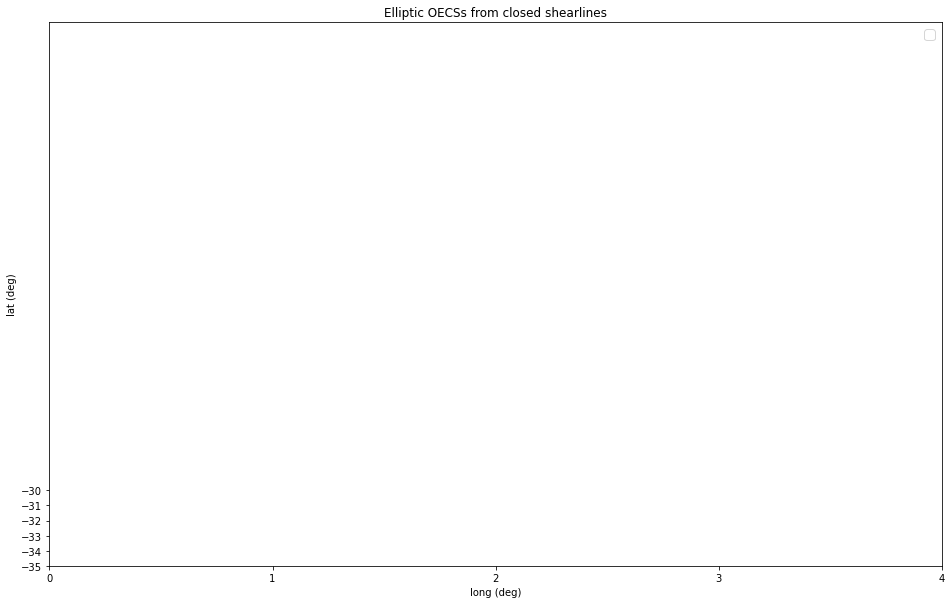

In [13]:
###################################### PLOT ELLIPTIC LCS ######################################

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()

for i in range(len(elliptic_OECS[0])):
    ax.plot(elliptic_OECS[0][i], elliptic_OECS[1][i], label = lambda_elliptic_OECS[i])

ax.set_xlabel('long (deg)')
ax.set_ylabel('lat (deg)')

ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

ax.set_title('Elliptic OECSs from closed shearlines')

plt.legend(loc = "upper right", fontsize = 14)
plt.show()

## Shrinklines (Repelling OECS)

Repelling LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0(s) = \xi_1(\mathbf{x}_0;t_0, t_N),
\label{eq: shrinklines}
\end{equation}

with $ \xi_1 $ denoting the eigenvector associated to the weakest eigenvalue $ s_1 $ of $ S(\mathbf{x},t) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ s_1 = s_2 $).
The most repelling shrinklines mark initial positions of repelling LCSs. Repelling LCSs can therefore be located as trajectories of eq. \ref{eq: shrinklines} that have locally the largest averaged $ s_2(\mathbf{x},t) $ among all neighbouring shrinklines.

In [ ]:
from ipynb.fs.defs.shrinklines import _shrinklines

# step-size used for integration with respect to parameter 's'
step_size = 0.02

# threshold distance to locate local maxima in the 's_2' field of 'S'
max_distance = 0.02

# maximum length of shrinkline
max_length = 20

shrinklines = _shrinklines(X_domain, Y_domain, S, max_distance, max_length, step_size, Incompressible)

In [ ]:
###################################### PLOT REPELLING LCS ######################################

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()
for i in range(len(elliptic_LCS[0])):
    ax.plot(shrinklines[0][i], shrinklines[1][i])
plt.legend(loc = "upper right", fontsize = 14)
plt.show()

## Stretchlines (Attracting OECS)

Attracting LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0 = \xi_2(\mathbf{x}_0;t_0, t_N),
\label{eq: stretchlines}
\end{equation}

with $ \xi_2 $ denoting the eigenvector associated to the strongest eigenvalue $ s_2 $ of $ S(\mathbf{x},t) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ s_1 = s_2 $).
The most attracting stretchlines mark initial positions of attracting LCSs. Attracting OECSs can therefore be located as trajectories of eq. \ref{eq: stretchlines} that have locally the smallest averaged $ s_1(\mathbf{x},t) $ among all neighbouring stretchlines.

In [ ]:
from ipynb.fs.defs.stretchlines import _stretchlines

# step-size used for integration with respect to parameter 's'
step_size = 0.01

# threshold distance to locate local minima in the 's_1' field of 'S'
max_distance = 0.02

# maximum length of stretchline
max_length = 20

stretchlines = _stretchlines(X_domain, Y_domain, S, max_distance, max_length, step_size, Incompressible)

In [ ]:
###################################### PLOT ATTRACTING OECS ######################################

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()
for i in range(len(stretchlines[0])):
    ax.plot(stretchlines[0][i], stretchlines[1][i], c = 'g')
    
ax.set_xlabel('x', fontsize = 16)
ax.set_ylabel('y', fontsize = 16)

ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, .1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, .1))

ax.set_title('Attracting LCSs from stretchlines', fontsize = 20)

plt.show()